In [3]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [4]:
# LOAD ROBOT
robot = loadKinton()
robot.initViewer(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

rmodel = robot.model

In [5]:
# DEFINE TARGET POSITION
target_pos  = np.array([0,0,1])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

# Plot goal frame
robot.viewer.gui.addXYZaxis('world/framegoal', [1., 0., 0., 1.], .015, 4)
robot.viewer.gui.applyConfiguration('world/framegoal', target_pos.tolist() + [target_quat[0], target_quat[1], target_quat[2], target_quat[3]])
robot.viewer.gui.refresh()

In [6]:
# ACTUATION MODEL
distanceRotorCOG = 0.1525
cf = 6.6e-5
cm = 1e-6
actModel = ActuationModelUAM(robot.model, distanceRotorCOG, cf, cm)

# COST MODEL
# Create a cost model per the running and terminal action model.
runningCostModel = CostModelSum(robot.model, actModel.nu)
terminalCostModel = CostModelSum(robot.model, actModel.nu)

frameName = 'base_link'
state = StatePinocchio(robot.model)
SE3ref = pin.SE3()
SE3ref.translation = target_pos.reshape(3,1)
SE3ref.rotation = target_quat.matrix()


wBasePos  = [1]
wBaseOri  = [500]
wArmPos   = [1]
wBaseVel  = [10]
wBaseRate = [10]
wArmVel   = [10] 
stateWeights   = np.array(wBasePos * 3 + wBaseOri * 3 + wArmPos * (robot.model.nv - 6) + wBaseVel * robot.model.nv)
controlWeights = np.array([0.1]*4 + [100]*6)

goalTrackingCost = CostModelFramePlacement(rmodel,
                                           frame=rmodel.getFrameId(frameName),
                                           ref=SE3ref,
                                           nu =actModel.nu)

xRegCost = CostModelState(rmodel, 
                          state, 
                          ref=state.zero(), 
                          nu=actModel.nu,
                          activation=ActivationModelWeightedQuad(stateWeights))
uRegCost = CostModelControl(rmodel, 
                            nu=robot.
                            model.nv-2,
                            activation = ActivationModelWeightedQuad(controlWeights))
uLimCost = CostModelControl(rmodel, 
                            nu=robot.
                            model.nv-2,
                            activation = ActivationModelInequality(np.array([0.1, 0.1, 0.1, 0.1, -1, -1, -1, -1, -1, -1]), 
                                                                np.array([5, 5, 5, 5, 1, 1, 1, 1, 1, 1])))

# Then let's add the running and terminal cost functions
runningCostModel.addCost(name="pos", weight=0.1, cost=goalTrackingCost)
runningCostModel.addCost(name="regx", weight=1e-4, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
# runningCostModel.addCost(name="limu", weight=1e-3, cost=uLimCost)
terminalCostModel.addCost(name="pos", weight=0, cost=goalTrackingCost)

# DIFFERENTIAL ACTION MODEL
runningModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))

In [ ]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

# Defining the time duration for running action models and the terminal one
dt = 1e-3
runningModel.timeStep = dt

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 1000
q0 = rmodel.referenceConfigurations["initial_pose"].copy()
v0 = pin.utils.zero(rmodel.nv)
x0 = m2a(np.concatenate([q0, v0]))
rmodel.defaultState = x0.copy()

problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

# Creating the DDP solver for this OC problem, defining a logger
fddp = SolverFDDP(problem)
fddp.callback = [CallbackDDPVerbose()]
fddp.callback.append(CallbackDDPLogger())

us0 = [
    m.differential.quasiStatic(d.differential, rmodel.defaultState)
    if isinstance(m, IntegratedActionModelEuler) else np.zeros(0)
    for m, d in zip(fddp.problem.runningModels, fddp.problem.runningDatas)]
xs0 = [problem.initialState]*len(fddp.models())

# Solving it with the DDP algorithm
#fddp.solve(init_xs=xs0, init_us=us0)
fddp.solve()

In [67]:
displayTrajectory(robot, fddp.xs, runningModel.timeStep)

In [68]:
# Control trajectory
f1 = []
f2 = [];
f3 = [];
f4 = [];

for u in fddp.us:
    f1.append(u[0])
    f2.append(u[1])
    f3.append(u[2])
    f4.append(u[3])

# State trajectory
Xx = [];
Xy = [];
Xz = [];
Vx = [];
Vy = [];
Vz = [];


for x in fddp.xs:
    Xx.append(x[0])
    Xy.append(x[1])
    Xz.append(x[2])
    Vx.append(x[13])
    Vy.append(x[14])
    Vz.append(x[15])

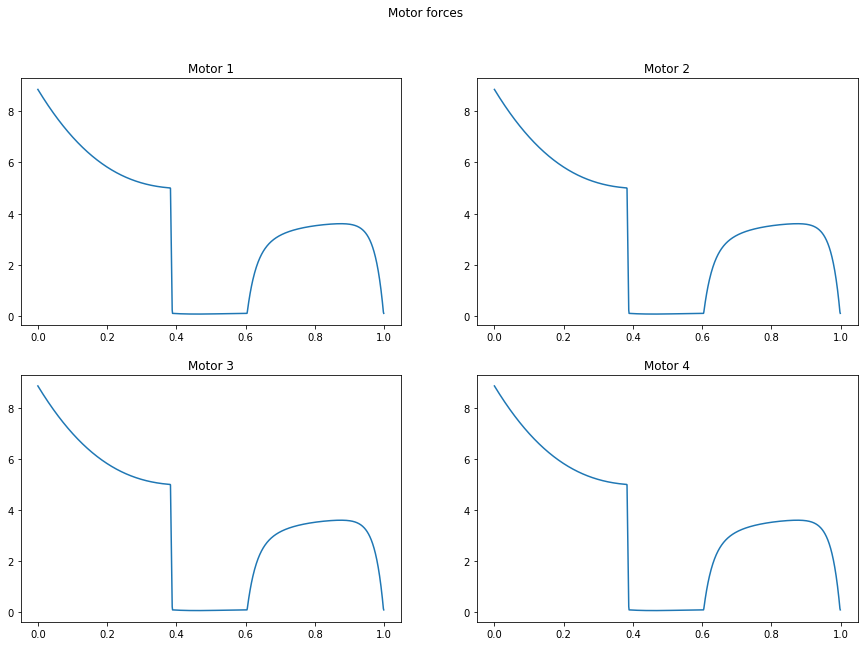

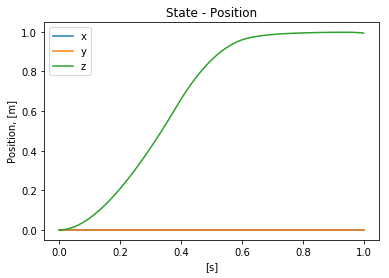

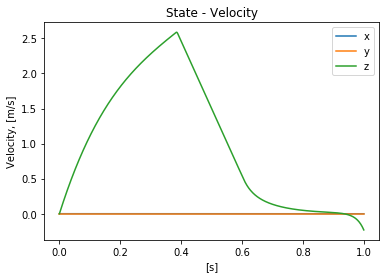

In [69]:
import matplotlib.pyplot as plt
t = np.arange(0., 1, dt)

fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Motor forces')
axs[0, 0].plot(t,f1)
axs[0, 0].set_title('Motor 1')
axs[0, 1].plot(t,f2)
axs[0, 1].set_title('Motor 2')
axs[1, 0].plot(t,f3)
axs[1, 0].set_title('Motor 3')
axs[1, 1].plot(t,f4)
axs[1, 1].set_title('Motor 4')

plt.figure()
t = np.append(t, 1)
plt.plot(t,Xx,t,Xy,t,Xz)
plt.legend(['x','y','z'])
plt.title('State - Position')
plt.ylabel('Position, [m]')
plt.xlabel('[s]')

plt.figure()
plt.plot(t,Vx,t,Vy,t,Vz)
plt.legend(['x','y','z'])
plt.title('State - Velocity')
plt.ylabel('Velocity, [m/s]')
plt.xlabel('[s]')